# Rendu TSA 

Mathieu Laversin 
Alexandra Mille egea
Ryan Pegoud

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [74]:
df = pd.read_csv('fr.csv')
df.head()

,start,end,load
0,2015-01-01 00:00:00+00:00,2015-01-01 01:00:00+00:00,70929.0
1,2015-01-01 01:00:00+00:00,2015-01-01 02:00:00+00:00,69773.0
2,2015-01-01 02:00:00+00:00,2015-01-01 03:00:00+00:00,66417.0
3,2015-01-01 03:00:00+00:00,2015-01-01 04:00:00+00:00,64182.0
4,2015-01-01 04:00:00+00:00,2015-01-01 05:00:00+00:00,63859.0


# **Descriptive analysis**

In [75]:
df.describe()

,load
count,48870.000000
mean,53556.308267
std,11682.584881
min,29398.000000
25%,44616.000000
50%,51932.000000
75%,61629.750000
max,158000.000000


# **Down sampling**

In [76]:
df['start'] = pd.to_datetime(df['start'], format='%Y/%m/%d %H:%M:%S')
df['end'] = pd.to_datetime(df['end'], format='%Y/%m/%d %H:%M:%S')

df.set_index('start', inplace=True)

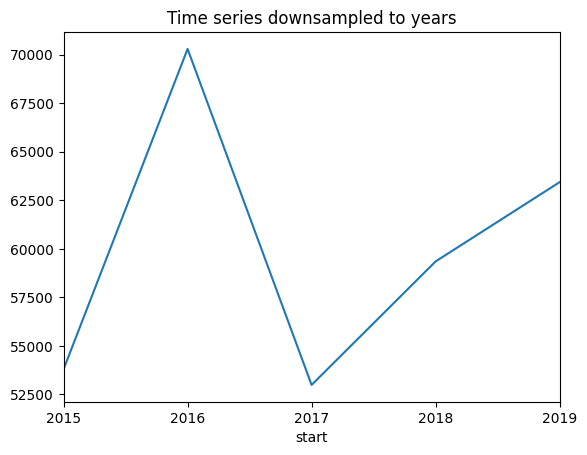

In [77]:
df["load"].asfreq('Y').plot()
plt.title('Time series downsampled to years')
plt.show()

In [78]:
df['year'] = pd.DatetimeIndex(df.index).year
yearly = df.groupby('year').agg('sum')
yearly

C:\Users\ryanp\AppData\Local\Temp\ipykernel_2988\1805939599.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly = df.groupby('year').agg('sum')


,load
year,
2015,470012917.0
2016,477474024.0
2017,475934939.0
2018,470394794.0
2019,467000414.0
2020,256479697.0


# **Monthly Moving Averages**

In [79]:
df['month'] = pd.DatetimeIndex(df.index).month
df_month_year= df.groupby(['year','month']).agg('mean')
df_month_year

C:\Users\ryanp\AppData\Local\Temp\ipykernel_2988\2700845858.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month_year= df.groupby(['year','month']).agg('mean')


load
year month              
2015 1      69523.116935
     2      71374.474702
     3      60624.438172
     4      50608.841667
     5      45209.040377
...                  ...
2020 3      55252.318489
     4      42409.579167
     5      40946.911290
     6      42225.624478
     7      44123.798387

[67 rows x 1 columns]

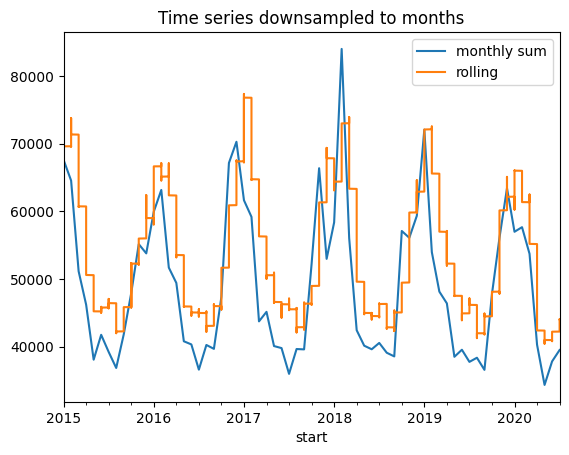

In [80]:
df["load"].asfreq('M').plot(label='monthly sum')

rolling_load = df.load.rolling('30D').mean()
rolling_load.plot(label='rolling')
plt.legend()
plt.title('Time series downsampled to months')
plt.show()

# **Seasonality**

In [81]:
melted_y_m = df.melt(id_vars=['year','month'], value_vars='load').drop('variable',axis=1)
melted_means = melted_y_m.groupby(['year','month']).agg('mean')
melted_means

value
year month              
2015 1      69523.116935
     2      71374.474702
     3      60624.438172
     4      50608.841667
     5      45209.040377
...                  ...
2020 3      55252.318489
     4      42409.579167
     5      40946.911290
     6      42225.624478
     7      44123.798387

[67 rows x 1 columns]

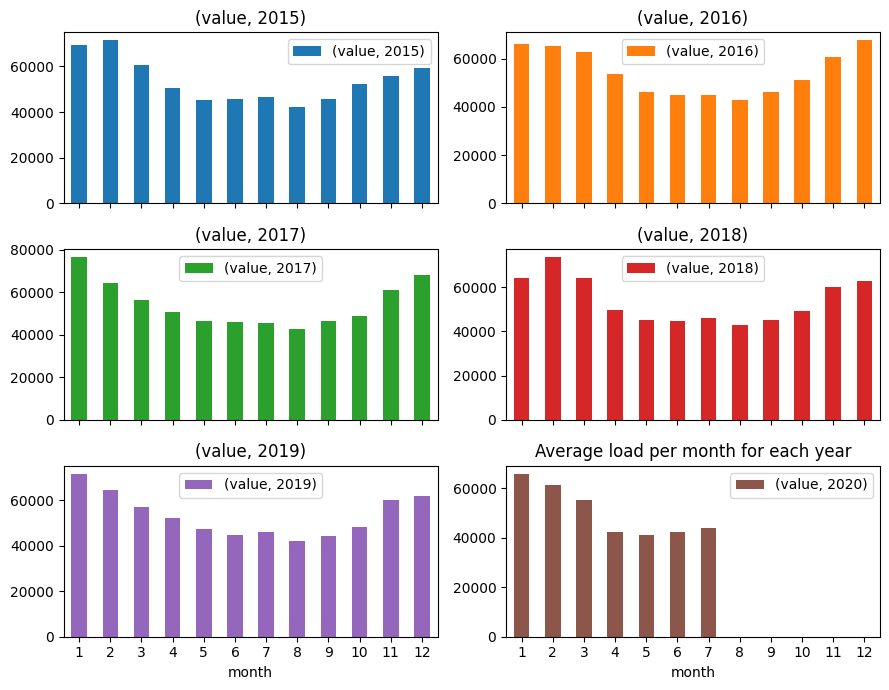

In [82]:
melted_means.unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(9, 7), layout=(3,2))
plt.title('Average load per month for each year')
plt.tight_layout()

In [83]:
melted_means['year'] = [melted_means.index[i][0] for i in range(melted_means.shape[0])]

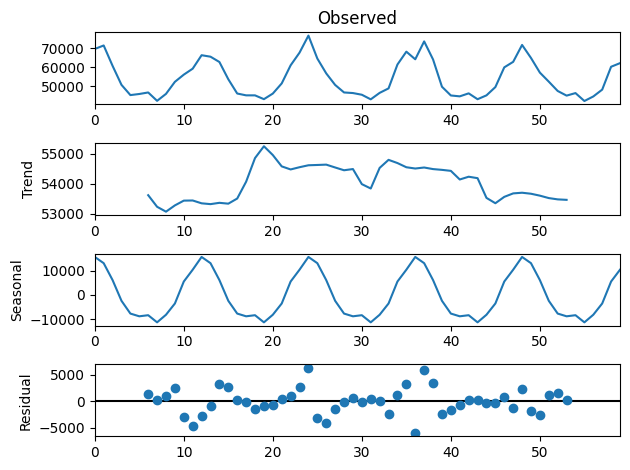

In [84]:
import statsmodels.api as sm

values = melted_means[melted_means['year']<2020]['value'] # monthly means between 2015 and 2019 (2020 is incomplete)
values = np.array(values, dtype=object)
decomposed = sm.tsa.seasonal_decompose(values, period=12) # yearly seasonality
decomposed.plot()
plt.show()

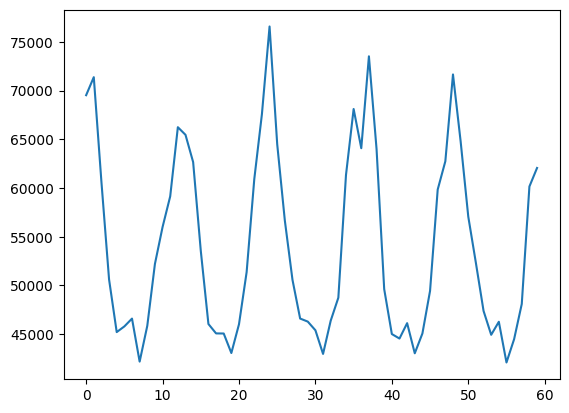

In [85]:
plt.plot(values)

In [86]:
train = melted_means[melted_means['year']<2018]
test = melted_means[melted_means['year'].between(2018,2020)]

In [87]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
# model = ExponentialSmoothing(values, trend='add')
# model_fit = model.fit()
# yhat = model_fit.predict(...)



Forecast with 2 methods

Explain our data, interpret result

Add / Mult

Expliquer 


Seasonality ok ! 

In [88]:
list_2015  = np.array(melted_means[melted_means['year'] == 2015].value)

list_2015_BBT = list_2015.argsort()[::-1]

In [89]:
list_2015  = np.array(melted_means[melted_means['year'] == 2015].value)
list_2016  = np.array(melted_means[melted_means['year'] == 2016].value)
list_2017  = np.array(melted_means[melted_means['year'] == 2017].value)
list_2018  = np.array(melted_means[melted_means['year'] == 2018].value)
list_2019  = np.array(melted_means[melted_means['year'] == 2019].value)

list_tot = zip(list_2015,list_2016, list_2017, list_2018,list_2019)

df = pd.DataFrame(list_tot, columns= ['2015', '2016', '2017', '2018','2019'],index=  ['1', '2', '3', '4', '5', '6','7','8', '9', '10', '11', '12'])
df = df.T

#find the index sorted
df_BBT = df.apply(lambda x : np.argsort(x)[::-1], axis = 1)

df_BBT = pd.DataFrame(df_BBT,columns=  ['1', '2', '3', '4', '5', '6','7','8', '9', '10', '11', '12'] )
        
df_BBT

,1,2,3,4,5,6,7,8,9,10,11,12
2015,7,4,5,8,6,3,9,10,11,2,0,1
2016,7,6,5,8,4,9,3,10,2,1,0,11
2017,7,6,5,8,4,9,3,2,10,1,11,0
2018,7,5,4,8,6,9,3,10,11,2,0,1
2019,7,8,5,6,4,9,3,2,10,11,1,0


# **Seasonal coefficients**

## **Detrending by differencing**

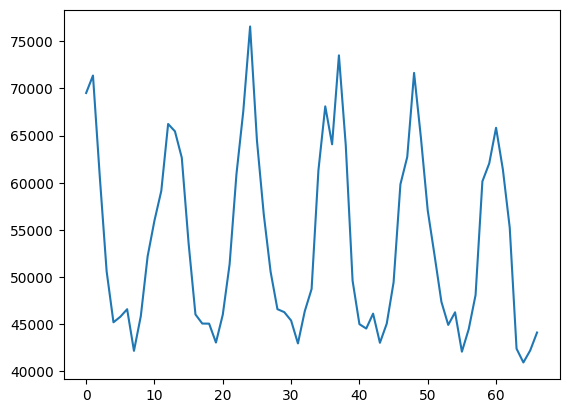

In [93]:
plt.plot(df_month_year.values)

## Detrending

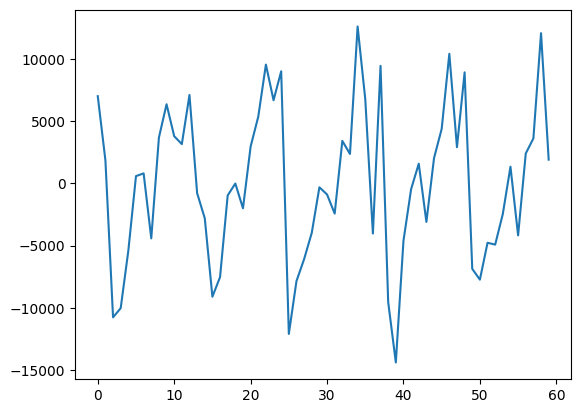

In [119]:
X = df_month_year.values
diff = [X[i] - X[i - 1] for i in range(1,len(X)-7)] # smoothing between 2015 and 2019
diff = np.insert(diff, 0, 7000, 0)
plt.plot(diff)

## Averaging by month

In [122]:
diff = diff.reshape(5, -1)
diff_df = pd.DataFrame(diff)
monthly_mean = diff_df.apply(np.mean, axis=0)
monthly_mean

0     5595.762161
1    -1688.402540
2    -7728.821717
3    -8866.289375
4    -5283.254205
5     -721.893232
6      563.567413
7    -3222.564096
8     2893.481405
9     4409.717571
10    9673.639122
11    4281.464254
dtype: float64

## Standardizing

In [124]:
mean_diff = np.mean(monthly_mean)
std_diff = np.std(monthly_mean)

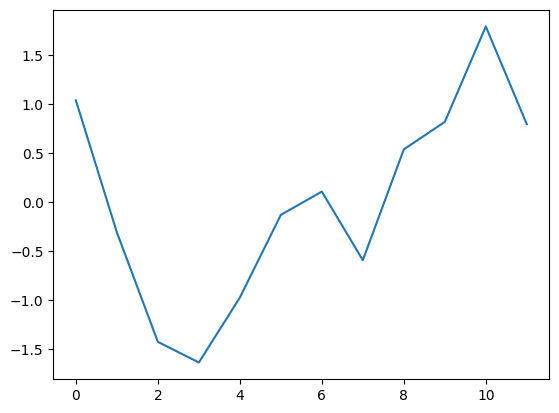

In [125]:
standardized = np.divide(np.subtract(monthly_mean, mean_diff), std_diff)
plt.plot(standardized)

In [128]:
pd.DataFrame(standardized).T

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.035549,-0.310579,-1.42686,-1.637066,-0.974914,-0.131966,0.10559,-0.594095,0.536162,0.816366,1.789149,0.792664


As the dataframe is quite simple we can see that the seasonality is rigid cause we can see a patern of month. 

Find the most frequent in the list and make a dataframe of the most frequent to see if the data is seasonal 

In [98]:
for i in df_BBT : 
    print(" The most common value in the month " + i , df_BBT[i].mode())

 The most common value in the month 1 0    7
Name: 1, dtype: int64
 The most common value in the month 2 0    6
Name: 2, dtype: int64
 The most common value in the month 3 0    5
Name: 3, dtype: int64
 The most common value in the month 4 0    8
Name: 4, dtype: int64
 The most common value in the month 5 0    4
Name: 5, dtype: int64
 The most common value in the month 6 0    9
Name: 6, dtype: int64
 The most common value in the month 7 0    3
Name: 7, dtype: int64
 The most common value in the month 8 0    10
Name: 8, dtype: int64
 The most common value in the month 9 0    10
1    11
Name: 9, dtype: int64
 The most common value in the month 10 0    1
1    2
Name: 10, dtype: int64
 The most common value in the month 11 0    0
Name: 11, dtype: int64
 The most common value in the month 12 0    0
1    1
Name: 12, dtype: int64
